# Estudo do impacto da vacinação na pandemia COVID-19 e nas ações das empresas produtoras de vacinas



*   Apache Spark
*   MongoDB
*   Power BI




De forma a poder usar o Apache Spark dentro do ambiente Python e Google Colab necessitamos das seguintes dependências:
1. Java
2. Apache Spark + Hadoop
3. Pyspark

O seguinte bloco de código descarrega e instala as dependências necessárias:

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark

^C
tar: spark-3.2.1-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 44 kB/s 
     |████████████████████████████████| 199 kB 55.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=d09b4e8df0dd67c21ea88c1fe053449b61e75327a93c69f31b4e2b9e0a19e4b9
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


Após a instalação das depêndencias é necessário importa-las no no nosso programa:


In [ ]:
from  pyspark.sql.functions import input_file_name
from pyspark.sql.types import *
import findspark
import pyspark

from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf, SparkContext

Após a importação poderemos começar a trabalhar. 

De forma a utilizar o Apache Spark é necessário criar uma *SparkSession* dentro do nosso programa. Este objeto conterá todas as configurações necessárias para o funcionamento desta etapa do *Pipeline* tal como a informação necessária que nos permitirá o armazenamento dos dados no *MongoDB*.

In [ ]:
conf = SparkConf().set("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1")
sc = SparkContext(conf=conf)

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .config("spark.mongodb.input.uri", "mongodb://localhost:27017/bigData.dados") \
        .config("spark.mongodb.output.uri", "mongodb://localhost:27017/bigData.dados") \
        .getOrCreate()

Para podermos ler os datasets é necessário que eles estejam presentes na nossa máquina, por isso teremos que os descarregar.

De notar que os datasets dos casos e vacinações contra o COVID estão atualizados até à data atual enquanto o dos stocks não contem informação completamente atualizada.

In [ ]:
!mkdir dataset

!wget -P dataset/ https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv
!wget -P dataset/ https://covid19.who.int/WHO-COVID-19-global-data.csv
!wget -P dataset/ https://cdn.discordapp.com/attachments/946357765754982440/948939040835657728/stocks.csv

--2022-06-17 14:41:20--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8344185 (8.0M) [text/plain]
Saving to: ‘dataset/vaccinations.csv’

vaccinations.csv    100%[===================>]   7.96M  --.-KB/s    in 0.03s   

2022-06-17 14:41:20 (242 MB/s) - ‘dataset/vaccinations.csv’ saved [8344185/8344185]

--2022-06-17 14:41:20--  https://covid19.who.int/WHO-COVID-19-global-data.csv
Resolving covid19.who.int (covid19.who.int)... 99.84.191.17, 99.84.191.117, 99.84.191.107, ...
Connecting to covid19.who.int (covid19.who.int)|99.84.191.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9560183 (9.1M) [text/csv]
Saving to: ‘dataset/WHO-CO

Com os datasets presentes poderemos começar a importá-los para o Apache Spark.

Para garantir o armazenamento correto é necessário definir uma arquitetura (ou Schema) de cada dataset, esta arquitetura contém a legenda de cada coluna tal como o tipo de dados armazenado na mesma.

In [ ]:
customSchema_CoVIDCases = StructType([ \
StructField("Date_Reported", DateType(), True), \
StructField("Country_code", StringType(), True), \
StructField("Country", StringType(), True), \
StructField("WHO_region", StringType(), True), \
StructField("New_cases", IntegerType(), True), \
StructField("Cumulative_cases", IntegerType(), True), \
StructField("New_deaths", IntegerType(), True), \
StructField("Cumulative_deaths", IntegerType(), True), \
])

customSchema_CoVIDVaccinations = StructType([ \
StructField("location", StringType(), True), \
StructField("iso_code", StringType(), True), \
StructField("date", DateType(), True), \
StructField("total_vaccinations", IntegerType(), True), \
StructField("people_vaccinated", IntegerType(), True), \
StructField("people_fully_vaccinated", IntegerType(), True), \
StructField("total_boosters", IntegerType(), True), \
StructField("daily_vaccinations_raw", IntegerType(), True), \
StructField("daily_vaccinations", IntegerType(), True), \
StructField("total_vaccinations_per_hundred", FloatType(), True), \
StructField("people_vaccinated_per_hundred", FloatType(), True), \
StructField("people_fully_vaccinated_per_hundred", FloatType(), True), \
StructField("total_boosters_per_hundred", FloatType(), True), \
StructField("daily_vaccinations_per_million", FloatType(), True), \
StructField("daily_people_vaccinated", IntegerType(), True), \
StructField("daily_people_vaccinated_per_hundred", FloatType(), True)
])

customSchema_stocks = StructType([ \
StructField("Company", StringType(), True), \
StructField("Date", DateType(), True), \
StructField("Open", FloatType(), True), \
StructField("High", FloatType(), True), \
StructField("Low", FloatType(), True), \
StructField("Close", FloatType(), True), \
StructField("Adj Close", FloatType(), True), \
StructField("Volume", IntegerType(), True), \
])


Importando os datasets com as Schemas obtemos as seguintes tabelas:

In [ ]:
df_CoVIDCases = spark.read.format("csv") \
   .option("header", "true") \
   .option("sep",",") \
   .schema(customSchema_CoVIDCases) \
   .load('/content/dataset/WHO-COVID-19-global-data.csv')

df_CoVIDVaccinations = spark.read.format("csv") \
   .option("header", "true") \
   .option("sep",",") \
   .schema(customSchema_CoVIDVaccinations) \
   .load('/content/dataset/vaccinations.csv')

df_stocks = spark.read.format("csv") \
   .option("header", "true") \
   .option("sep",",") \
   .schema(customSchema_stocks) \
   .load('/content/dataset/stocks.csv')

print("###CASOS###")
df_CoVIDCases.printSchema()
df_CoVIDCases.show(n=10)
print(df_CoVIDCases.count())
print("###VACINACOES###")
df_CoVIDVaccinations.printSchema()
df_CoVIDVaccinations.show(n=10)
print(df_CoVIDVaccinations.count())
print("###STOCKS###")
df_stocks.printSchema()
df_stocks.show(n=10)

###CASOS###
root
 |-- Date_Reported: date (nullable = true)
 |-- Country_code: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- WHO_region: string (nullable = true)
 |-- New_cases: integer (nullable = true)
 |-- Cumulative_cases: integer (nullable = true)
 |-- New_deaths: integer (nullable = true)
 |-- Cumulative_deaths: integer (nullable = true)

+-------------+------------+-----------+----------+---------+----------------+----------+-----------------+
|Date_Reported|Country_code|    Country|WHO_region|New_cases|Cumulative_cases|New_deaths|Cumulative_deaths|
+-------------+------------+-----------+----------+---------+----------------+----------+-----------------+
|   2020-01-03|          AF|Afghanistan|      EMRO|        0|               0|         0|                0|
|   2020-01-04|          AF|Afghanistan|      EMRO|        0|               0|         0|                0|
|   2020-01-05|          AF|Afghanistan|      EMRO|        0|               0|         0| 

**Algumas observações pertinentes:**
- O dataset das vacinações não contem informação diária completa. Algumas colunas são atualizadas semanalmente.
- O mercado de stocks está fechado ao fim de semana logo não existe informação para esses dias.



Após a importação das datasets poderemos começar o estudo das suas junções.

Comecemos por juntar os primeiros 2 datasets.

De forma a facilitar o processo podemos igualar o nome das colunas cuja informação contida em ambos os datasets é igual.

De seguida juntaremos ambos os datasets utilizando um left outer join de forma a manter o formato do primeiro dataset.

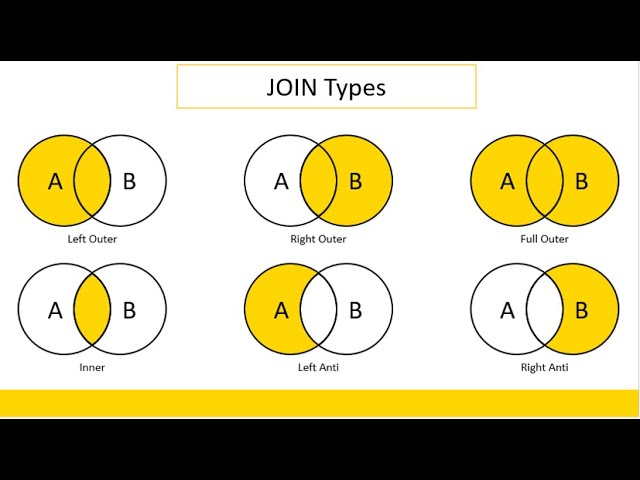

In [ ]:
df_CoVIDCases = df_CoVIDCases.withColumnRenamed("Date_Reported","Date")
df_CoVIDVaccinations = df_CoVIDVaccinations.withColumnRenamed("location","Country")

partialDataset = df_CoVIDCases.join(df_CoVIDVaccinations,["Country","Date"],'left')
partialDataset.show(n=10)
print(f"Numero de linhas: {partialDataset.count()}")
print(f"Numero de elementos: {(partialDataset.count() * len(partialDataset.columns))}")

+-----------+----------+------------+----------+---------+----------------+----------+-----------------+--------+------------------+-----------------+-----------------------+--------------+----------------------+------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+------------------------------+-----------------------+-----------------------------------+
|    Country|      Date|Country_code|WHO_region|New_cases|Cumulative_cases|New_deaths|Cumulative_deaths|iso_code|total_vaccinations|people_vaccinated|people_fully_vaccinated|total_boosters|daily_vaccinations_raw|daily_vaccinations|total_vaccinations_per_hundred|people_vaccinated_per_hundred|people_fully_vaccinated_per_hundred|total_boosters_per_hundred|daily_vaccinations_per_million|daily_people_vaccinated|daily_people_vaccinated_per_hundred|
+-----------+----------+------------+----------+---------+----------------+----------+-----------------+--

Vale relembrar que existem várias linhas no *dataset* que não contêm nenhuma informação pertinente relacionada com o *dataset* das vacinações. Isto deve-se ao facto da introdução da vacina não ter acontecido ao mesmo tempo que o aparecimento de casos, logo, há um grande intervalo de tempo onde só existe informação referente ao primeiro *dataset*. Para além disso, mais uma vez relembramos que este *dataset* não contém informação diária completa, pois, para alguns países, algumas colunas apenas são atualizadas semanalmente.

Para tratarmos destes *missing values* do *dataset*, vamos substituir esses mesmos valores pelos do elemento anterior não nulo mais próximo. Porém, este método acabará por causar problemas visto que a informação das últimas linhas referentes a um certo país pode contaminar as linhas de outro, caso a primeira linha deste contenha nulos.

De modo a contornar este problema vamos substituir todos os valores nulos da primeira linha de cada país por 0, o que está factualmente correto visto que não houve nenhuma vacinação nessas datas. Para alcançarmos este objetivo filtraremos essas linhas, substituímos os valores e juntamos as linhas filtradas ao *dataset* original, utilizando o ***union*** de tabelas.

In [ ]:
from pyspark.sql.functions import last,col, row_number
from pyspark.sql.window import Window
import sys

w2 = Window.partitionBy("Country").orderBy(col("Date"))
df=partialDataset.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row") \
  .fillna(0)

w2 = Window.partitionBy("Country").orderBy(col("Date"))
partialDataset=partialDataset.withColumn("row",row_number().over(w2)) \
  .filter(col("row") != 1).drop("row")

partialDataset = partialDataset.union(df)

Com a união executada poderemos substituir os valores nulos do dataset todo utilizando o metodo referido anteriormente.

In [ ]:
window_last = Window.orderBy(["Country","Date"])
for column in partialDataset.columns:
  partialDataset = partialDataset.withColumn(column, last(column, ignorenulls=True).over(window_last))

partialDataset.show(n=10)

+-----------+----------+------------+----------+---------+----------------+----------+-----------------+--------+------------------+-----------------+-----------------------+--------------+----------------------+------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+------------------------------+-----------------------+-----------------------------------+
|    Country|      Date|Country_code|WHO_region|New_cases|Cumulative_cases|New_deaths|Cumulative_deaths|iso_code|total_vaccinations|people_vaccinated|people_fully_vaccinated|total_boosters|daily_vaccinations_raw|daily_vaccinations|total_vaccinations_per_hundred|people_vaccinated_per_hundred|people_fully_vaccinated_per_hundred|total_boosters_per_hundred|daily_vaccinations_per_million|daily_people_vaccinated|daily_people_vaccinated_per_hundred|
+-----------+----------+------------+----------+---------+----------------+----------+-----------------+--

In [ ]:
finalDataset = partialDataset.join(df_stocks,["Date"],'left')
finalDataset.show(n=10)

print(f"Numero de linhas: {finalDataset.count()}")
print(f"Numero de elementos: {(finalDataset.count() * len(finalDataset.columns))}")

+----------+-----------+------------+----------+---------+----------------+----------+-----------------+--------+------------------+-----------------+-----------------------+--------------+----------------------+------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+------------------------------+-----------------------+-----------------------------------+-------+---------+---------+---------+---------+---------+--------+
|      Date|    Country|Country_code|WHO_region|New_cases|Cumulative_cases|New_deaths|Cumulative_deaths|iso_code|total_vaccinations|people_vaccinated|people_fully_vaccinated|total_boosters|daily_vaccinations_raw|daily_vaccinations|total_vaccinations_per_hundred|people_vaccinated_per_hundred|people_fully_vaccinated_per_hundred|total_boosters_per_hundred|daily_vaccinations_per_million|daily_people_vaccinated|daily_people_vaccinated_per_hundred|Company|     Open|     High|      Low|  

Como conseguimos ver o numero de linhas e elementos aumentou considerávelmente o que não é positivo visto que a maior parte da informação adicionada é redundante. 

A maioria das linhas do dataset foram quadriplicadas para juntar a informação referente a cada uma das 4 empresas presentes no dataset dos stocks.

De forma a resolver este problema podemos "rodar" o dataset dos stocks de forma a que a informação referente a cada empresa esteja armazenada por colunas e não por linhas.

O seguinte excerto de código pega no dataset dos stocks e roda-o guardando-o num novo ficheiro CSV.

In [ ]:
with open("dataset/stocks.csv",'r') as f:
    dataset = f.readlines()
    titulo = dataset[0].split(',')
    dataset=dataset[1:]

new_dataset = {}
for linha in dataset:
    info = linha.split(',')
    if info[1] not in new_dataset:
        new_dataset[info[1]] = {}
    for index in range(2,len(info)):
        new_dataset[info[1]][f"{info[0]}_{titulo[index]}"] = info[index] 
        
with open("dataset/new_stocks.csv",'w') as f:
    f.write(f"date,{','.join(new_dataset['2020-01-13'].keys())}".replace("\n","")+"\n")
    for key,value in new_dataset.items():
        f.write(",".join([key]+list(value.values())).replace('\n','')+'\n')


In [ ]:
customSchema_newstocks = StructType([ \
StructField("Date", DateType(), True), \
StructField("JNJ_Open", FloatType(), True), \
StructField("JNJ_High", FloatType(), True), \
StructField("JNJ_Low", FloatType(), True), \
StructField("JNJ_Close", FloatType(), True), \
StructField("JNJ_Adj Close", FloatType(), True), \
StructField("JNJ_Volume", IntegerType(), True), \
StructField("PFE_Open", FloatType(), True), \
StructField("PFE_High", FloatType(), True), \
StructField("PFE_Low", FloatType(), True), \
StructField("PFE_Close", FloatType(), True), \
StructField("PFE_Adj Close", FloatType(), True), \
StructField("PFE_Volume", IntegerType(), True), \
StructField("AZN_Open", FloatType(), True), \
StructField("AZN_High", FloatType(), True), \
StructField("AZN_Low", FloatType(), True), \
StructField("AZN_Close", FloatType(), True), \
StructField("AZN_Adj Close", FloatType(), True), \
StructField("AZN_Volume", IntegerType(), True), \
StructField("MRNA_Open", FloatType(), True), \
StructField("MRNA_High", FloatType(), True), \
StructField("MRNA_Low", FloatType(), True), \
StructField("MRNA_Close", FloatType(), True), \
StructField("MRNA_Adj Close", FloatType(), True), \
StructField("MRNA_Volume", IntegerType(), True), \
])

df_stocks = spark.read.format("csv") \
   .option("header", "true") \
   .option("sep",",") \
   .schema(customSchema_newstocks) \
   .load('/content/dataset/new_stocks.csv')

df_stocks.printSchema()
df_stocks.show(n=10)

root
 |-- Date: date (nullable = true)
 |-- JNJ_Open: float (nullable = true)
 |-- JNJ_High: float (nullable = true)
 |-- JNJ_Low: float (nullable = true)
 |-- JNJ_Close: float (nullable = true)
 |-- JNJ_Adj Close: float (nullable = true)
 |-- JNJ_Volume: integer (nullable = true)
 |-- PFE_Open: float (nullable = true)
 |-- PFE_High: float (nullable = true)
 |-- PFE_Low: float (nullable = true)
 |-- PFE_Close: float (nullable = true)
 |-- PFE_Adj Close: float (nullable = true)
 |-- PFE_Volume: integer (nullable = true)
 |-- AZN_Open: float (nullable = true)
 |-- AZN_High: float (nullable = true)
 |-- AZN_Low: float (nullable = true)
 |-- AZN_Close: float (nullable = true)
 |-- AZN_Adj Close: float (nullable = true)
 |-- AZN_Volume: integer (nullable = true)
 |-- MRNA_Open: float (nullable = true)
 |-- MRNA_High: float (nullable = true)
 |-- MRNA_Low: float (nullable = true)
 |-- MRNA_Close: float (nullable = true)
 |-- MRNA_Adj Close: float (nullable = true)
 |-- MRNA_Volume: integer (

In [ ]:
finalDataset = partialDataset.join(df_stocks,["Date"],'left')
finalDataset.show(n=10)

print(f"Numero de linhas: {finalDataset.count()}")
print(f"Numero de elementos: {(finalDataset.count() * len(finalDataset.columns))}")

+----------+-----------+------------+----------+---------+----------------+----------+-----------------+--------+------------------+-----------------+-----------------------+--------------+----------------------+------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+------------------------------+-----------------------+-----------------------------------+--------+--------+-------+---------+-------------+----------+---------+---------+---------+---------+-------------+----------+--------+--------+-------+---------+-------------+----------+---------+---------+--------+----------+--------------+-----------+
|      Date|    Country|Country_code|WHO_region|New_cases|Cumulative_cases|New_deaths|Cumulative_deaths|iso_code|total_vaccinations|people_vaccinated|people_fully_vaccinated|total_boosters|daily_vaccinations_raw|daily_vaccinations|total_vaccinations_per_hundred|people_vaccinated_per_hundred|people_

Como conseguimos ver com o novo dataset de stocks o numero de linhas baixou considerávelmente visto que já não temos linhas repetidas.

O dataset ainda contém alguma informação redundante em relação aos stocks mas a sua abundância é mais aceitável que na solução anterior.

Antes de inserir a informação na base de dados poderemos executar mais algum pré processamento de forma a obtermos dados mais limpos.

Começaremos por remover algumas colunas desnecessárias para o nosso caso de uso:

In [ ]:
finalDataset=finalDataset.drop('iso_code','daily_vaccinations_raw')

finalDataset.show(n=10)

print(f"Numero de linhas: {finalDataset.count()}")
print(f"Numero de elementos: {(finalDataset.count() * len(finalDataset.columns))}")

+----------+-----------+------------+----------+---------+----------------+----------+-----------------+------------------+-----------------+-----------------------+--------------+------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+------------------------------+-----------------------+-----------------------------------+--------+--------+-------+---------+-------------+----------+---------+---------+---------+---------+-------------+----------+--------+--------+-------+---------+-------------+----------+---------+---------+--------+----------+--------------+-----------+
|      Date|    Country|Country_code|WHO_region|New_cases|Cumulative_cases|New_deaths|Cumulative_deaths|total_vaccinations|people_vaccinated|people_fully_vaccinated|total_boosters|daily_vaccinations|total_vaccinations_per_hundred|people_vaccinated_per_hundred|people_fully_vaccinated_per_hundred|total_boosters_per_hundred|daily_va

Anteriormente, substituímos os valores nulos no *dataset* das vacinações, e procedemos agora à substituição dos valores nulos no *dataset* dos *stocks*. Obviamente que não podemos utilizar a estratégia de colocar todos os valores igual a 0, pois isso significaria que as empresas perdiam todo o seu valor ao fim de semana, uma informação muito enganadora.

Novamente, a solução que vamos utilizar é substituir o valor nulo pelo valor não nulo mais próximo do mesmo. Apesar de este método não produzir dados 100\% corretos, este mostra que o valor das *stocks* de uma empresa mantém-se enquanto o mercado está fechado, que acaba por ser uma suposição correta a fazer.

Também utilizaremos a mesma estratégia para as restantes colunas visto que o *dataset* já foi corretamente pré-processado.

In [ ]:

window_last = Window.orderBy(["Country","Date"])
for column in finalDataset.columns:
  finalDataset = finalDataset.withColumn(column, last(column, ignorenulls=True).over(window_last))


In [ ]:
print(f"Numero de linhas: {finalDataset.count()}")
print(f"Numero de elementos: {(finalDataset.count() * len(finalDataset.columns))}")

Numero de linhas: 212352
Numero de elementos: 9343488


Agora que temos os dados prontos poderemos começar a preparar o armazenamento na base de dados.

Começaremos por instalar o MongoDB

In [ ]:
!apt install mongodb
!service mongodb start

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libpcap0.8 libstemmer0d libyaml-cpp0.5v5 mongo-tools mongodb-clients
  mongodb-server mongodb-server-core
The following NEW packages will be installed:
  libpcap0.8 libstemmer0d libyaml-cpp0.5v5 mongo-tools mongodb mongodb-clients
  mongodb-server mongodb-server-core
0 upgraded, 8 newly installed, 0 to remove and 49 not upgraded.
Need to get 53.1 MB of archives.
After this operation, 215 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpcap0.8 amd64 1.8.1-6ubuntu1.18.04.2 [118 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libstemmer0d amd64 0+svn585-1build1 [62.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 lib

Com o mongoDB instalado poderemos criar uma base de dados e uma coleção para armazenar a informação

In [ ]:
from pymongo import MongoClient
client = MongoClient("mongodb://localhost:27017/")
bigDataDB = client["bigData"]
dados = bigDataDB["dados"]

In [ ]:
client.list_database_names() # ['admin', 'local']
print(bigDataDB.list_collection_names())

[]


Com a base de dados pronta basta escrever a informação toda para lá

In [ ]:
finalDataset.write.format("com.mongodb.spark.sql.DefaultSource").option("spark.mongodb.output.uri", "mongodb://127.0.0.1/bigData.dados").mode("append").save()


In [ ]:
print(list(bigDataDB["dados"].find().limit(20)))

[{'_id': ObjectId('62ac93126600e548a4c92193'), 'Date': datetime.datetime(2020, 1, 3, 0, 0), 'Country': 'Afghanistan', 'Country_code': 'AF', 'WHO_region': 'EMRO', 'New_cases': 0, 'Cumulative_cases': 0, 'New_deaths': 0, 'Cumulative_deaths': 0, 'total_vaccinations': 0, 'people_vaccinated': 0, 'people_fully_vaccinated': 0, 'total_boosters': 0, 'daily_vaccinations': 0, 'total_vaccinations_per_hundred': 0.0, 'people_vaccinated_per_hundred': 0.0, 'people_fully_vaccinated_per_hundred': 0.0, 'total_boosters_per_hundred': 0.0, 'daily_vaccinations_per_million': 0.0, 'daily_people_vaccinated': 0, 'daily_people_vaccinated_per_hundred': 0.0, 'JNJ_Open': 143.5, 'JNJ_High': 145.3699951171875, 'JNJ_Low': 143.0, 'JNJ_Close': 144.27999877929688, 'JNJ_Adj Close': 136.13470458984375, 'JNJ_Volume': 5752400, 'PFE_Open': 36.736244201660156, 'PFE_High': 37.2296028137207, 'PFE_Low': 36.688804626464844, 'PFE_Close': 36.93548583984375, 'PFE_Adj Close': 33.89201736450195, 'PFE_Volume': 14922848, 'AZN_Open': 49.880

In [ ]:
!mongodump

2022-06-17T14:43:47.141+0000	writing admin.system.version to 
2022-06-17T14:43:47.142+0000	done dumping admin.system.version (1 document)
2022-06-17T14:43:47.142+0000	writing bigData.dados to 
2022-06-17T14:43:48.334+0000	done dumping bigData.dados (212352 documents)


In [ ]:
finalDataset.filter(col("Country")=="Portugal").show(n=100)

+----------+--------+------------+----------+---------+----------------+----------+-----------------+------------------+-----------------+-----------------------+--------------+------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+------------------------------+-----------------------+-----------------------------------+--------+--------+-------+---------+-------------+----------+---------+---------+---------+---------+-------------+----------+--------+--------+-------+---------+-------------+----------+---------+---------+--------+----------+--------------+-----------+
|      Date| Country|Country_code|WHO_region|New_cases|Cumulative_cases|New_deaths|Cumulative_deaths|total_vaccinations|people_vaccinated|people_fully_vaccinated|total_boosters|daily_vaccinations|total_vaccinations_per_hundred|people_vaccinated_per_hundred|people_fully_vaccinated_per_hundred|total_boosters_per_hundred|daily_vaccinat